#### Аттестационный семинар в Сайберс
 
# Критика Django и правильная архитектура в Django проектах


 
###### Подготовил пайтон-разработчик Федоров Вячеслав
###### Проверил тимлид Андрей Харченко

## План семинара

1. MVC
2. Бизнес-логика в Django
3. Правильная архитектура Django проектов
4. Примеры

## MVC?

Когда начинаем изучать `Django`, помимо документации мы читаем туториалы, статьи, книги, и почти во всех видим что-то подобное:

> `Django` — это фреймворк, использующий шаблон проектирования *Model-View-Controller (MVC).*

### MVC

Обычно в таких схемах *MVC* описывают подобным образом:

- **Model** — доступ к хранилищу данных

- **View** — это интерфейс, с которым взаимодействует пользователь 

- **Controller** — некий связывающий объект между model и view.

Стоит обратить внимание на две вещи.

### Модель

**Под M подразумевается domain model** — объектная модель домена, объединяющая данные и поведение. Если говорить точнее, то M в MVC это интерфейс к доменной модели, так как domain model это некий слой объектов, описывающий различные стороны определенной области бизнеса. Где одни объекты призваны имитировать элементы данных, которыми оперируют в этой области, а другие должны формализовать те или иные бизнес-правила.

### Контроллер

**В Django нет выделенного слоя controller** - как говорится в FAQ, если вам очень хочется аббревиатур, то можно использовать в контексте Django аббревиатуру MTV (Model, Template, and View). Если очень хочется рассматривать Web MVC  и сравнивать Django с другими фреймворками, то для простоты можно считать view контроллером.

### Итого

**Django не соответствует MVC аббревиатуре** — но в ней реализуется главный смысл MVC — отделение бизнес-логики от логики представления данных. 

*Но на практике это не всегда так по нескольким причинам, которые мы рассмотрим ниже.*

## Бизнес логика в Django приложениях

Выделим в `Django` приложениях несколько слоев, которые есть почти в каждом проекте:

- `templates` | `frontend`
- `forms` | `serializers`
- `views`
- `models`


### Простой кейс

Разберемся на простом кейсе, что стоит помещать в каждом из слоев и какая ответственность у каждого слоя. 

Создание заказа:

- проверка валидности заказа
- создание заказа
- резервирование товара
- оповещение менеджера/админа
- оповещение пользователя

### Слой serializers/forms

У слоя Serializers две основные функции (все выводы для `serializers` справедливы и для `forms`):

- валидировать данные
- преобразовывать данные

Дополнительно сериалайзеры имеют два метода, `create` и `update`, которые вызываются в методе `save()` и почти всегда используются во `view`.

Некоторым, кажется, что переопределение `create` отличное место для того, чтобы описать там все бизнес-процессы :)

```python
class OrderSerializer(ModelSerializer):
    ...

    def create(self, validated_data):
        ...
        
        # Проверяем, что заказ валиден
        ...
        
        # Создаем запись о заказе в БД
        instance = super(OrderSerializer, self).create(validated_data)
        
        # Бронируем товары на складе
        ...
        
        # Передаем заявку менеджеру
        ...
        
        # Оповещаем пользователя
        ...
        
        return instance
```

#### Плюсы данного подхода:

- **Легко делать CRUD**

#### Минусы данного подхода: 


- **Нарушение идей MVC**

    Сериалайзеры стоит относить к слою `View` в MVC в контексте `Django`.


- **Нельзя переиспользовать**
 
    Не получится переиспользовать логику одного сериалайзера в другом сериалайзере, или в каком-то другом компоненте.


- **Сложно тестировать**

    Сложно протестировать бизнес-логику независимо от логики сериализации и валидации данных.


- **Сложно поддерживать**

    Бизнес-правила разбросаны по всему проекту, которые невозможно переиспользовать и очень сложно поддерживать.


- **Высокая зависимость от фреймворка**

    Высокая зависимость от `DRF` или `Django Forms`.

#### Правильные обязанности слоя serializers/forms


- **Сериализация данных**

    Сериалайзер хорошо умеет сериализовывать данные, для этого его и нужно использовать.


- **Валидация данных**

    Без написания кастомных валидаторов. Если вам требуется написать кастомный валидатор, то, скорее всего, это бизнес-правило, и данную проверку лучше вынести в слой с бизнес-логикой (где бы он ни был).
    

#### Заключение

Сериалайзеры точно не подходят для написания в них бизнес-логики. Если вам нужно что-то большее, чем CRUD, то стоит отказаться от использования метода `save` у сериалайзеров, так как сохранение данных не должно входить в их обязанности.

### Слой Views

Слой View в контексте `Django` отвечает за представление и обработку пользовательских данных, в нем мы описываем, какие данные нам нужны и как мы хотим их представить. Если вспомнить то, о чем мы говорили в начале, то можно сразу сделать вывод, что во `views` не нужно писать бизнес-логику, иначе мы смешиваем логику представления данных с бизнес-логикой. Даже если считать, что `views` в `Django` это контроллеры, то размещать в них бизнес-логику тоже не стоит, иначе у вас получатся - *Fat Stupid Ugly Controllers.*

Но часто можно увидеть что-то подобное :)

```python
class OrderCreateApi(views.APIView):
  ...

  def post(self, request):
    ...
        
    # Проверяем, что заказ валиден
    ...

    # Создаем запись о заказе в БД                                         
    order = Order.objects.create(**serializer.validated_data)

    # Бронируем товары на складе
    ...

    # Передаем заявку менеджеру
    ...

    # Оповещаем пользователя
    ...           

    return Response(status=status.HTTP_201_CREATED)
```

#### Плюсы данного подхода:

- **Легко делать CRUD**

#### Минусы данного подхода: 


- **Нарушение идей MVC**

    Мы смешиваем в одном слое логику представления данных и бизнес-логику приложения.


- **Нельзя переиспользовать**
 
    Не получится переиспользовать логику одной `view` в другой `view`, или в каком-то другом компоненте.


- **Сложно тестировать**

    Достаточно сложно протестировать код во `views` независимо от `serializers` и остальной инфраструктуры `Django`.


- **Сложно поддерживать**

    Со временем `views` разрастаются, часть логики переносится в `Celery` задачи, часть в модели.


- **Высокая зависимость от фреймворка**

    Высокая зависимость от `DRF View` или `Django View`.

#### Правильные обязанности слоя views


- **Обработка запроса**

    Во view мы принимаем и обрабатываем запрос клиента, подготавливаем данные для передачи в бизнес-логику.


- **Делегирование сериализации данных сериалайзерам**

    Всю логику сериализации данных должны выполнять сериалайзеры.


- **Вызов методов бизнес-логики**

    После подготовки и сериализации данных вызывается интерфейс бизнес-логики.


- **Логика представления данных**

    Мы должны обработать ответ от методов бизнес-логики и предоставить нужные данные клиенту.
    

#### Заключение

В `views` не стоит размещать бизнес-логику.

Стоит отказаться от `ModelViewSet` и миксинов, так как они используют сериалайзеры для сохранения данных, вместо этого использовать обычные `APIView`.

*Если нужен только CRUD - то можно использовать подход который предоставляет `ModelViewSet` и не усложнять себе жизнь.*

### Слой Models

Если вспомнить слой Model в MVC, то кажется, что `models` отличное место для размещения бизнес-логики.

Часто можно увидеть что-то подобное :)


```python
class Order(models.Model):
  ...
  
  @classmethod
  def create(cls, data...):
    ...
    
    # Проверяем, что все товары есть и заказ валиден
    ...
    
    # Создаем запись о заказе в БД
    instance = instance.save()
    
    # Бронируем товары на складе
    ...
    
    # Передаем заявку менеджеру
    ...
    
    # Оповещаем пользователя
    ...

```

**Стоит заметить, что не нужно писать бизнес-логику в методе `save()`, так как это базовый метод модели и он может неоднократно использоваться в различных частях кода!!!**

#### Плюсы данного подхода:

- **Следование идеям MVC**

    Мы отделили логику представления данных от логики предметной области. View только подготавливает данные и вызывает методы модели, все бизнес правила и процессы описаны в методах модели. Данный подход соответствует главной идее MVC.


- **Легко тестировать**

    Вся бизнес-логика собрана в одном слое, который не зависит от других слоев, например, от `views` или `serializers`. Каждый метод модели можно протестировать по отдельности как обычный `python` код.


- **Можно переиспользовать**

    Методы модели можно вызывать из любого компонента: `DRF Views`, `Django Views`, `Celery` задачи и т.д.

#### Минусы данного подхода: 


- **Зависимость от фреймворка**

    У нас все еще есть зависимость от фреймворка, но это не так критично. Так как отказ от Django models и ORM или их замена — очень редкий кейс.
    

- **Сложно поддерживать большие проекты**

    В больших проектах много бизнес-правил и если все их описывать в одном классе модели, то модель разрастается и превращается в божественный объект, который сложно читать и поддерживать. Сложно масштабировать и разделять код по файлам, так как мы ограничены требованиями фреймворка. Непонятно, куда помещать методы, которые оперируют несколькими моделями, возможно, из разных модулей. 


- **Усложнение CRUD проектов**

    Если вам нужен только CRUD, то данный подход увеличивает время разработки и не приносит плюсов.

#### Правильные обязанности слоя views

...

#### Заключение

Мы не нарушили главных идей MVC и наш код соответствует им. Такой подход можно использовать в малых проектах, когда бизнес-логики не много и она умещается в классах моделей.

### Слой Services

Мы перебрали все дефолтные слои в `Django` приложении, теперь можем вспомнить о том, что под слоем Model в MVC подразумевается не один объект, а набор объектов. 

Выделим отдельный сервисный слой Services внутри слоя Model, который будет отвечать за бизнес-правила предметной области и приложения. В models оставить только простые `property`, в которых нет сложных бизнес-правил, и методы для работы с собственными данными модели, например обновление полей. 

```python
def order_create(name: str, number: int ...) -> bool:
    # Проверяем, что все товары есть и заказ валиден
    ...
    
    # Создаем запись о заказе в БД
    order = Order.objects.create(...)
    
    # Бронируем товары на складе
    ...
    
    # Передаем заявку менеджеру
    ...
    
    # Оповещаем пользователя
    ...
    
    return True
```

Стоит придерживаться следующему подходу:

 - `views` — подготовка данных запроса, вызов бизнес логики, подготовка ответа

 - `serializers` — сериализация данных, простая валидация

 - `services` — простые функции с бизнес правилами или классы (Service Objects)

 - `managers` — содержит в себе правила работы с данными (доступ к данным)

 - `models` — единственный окончательный источник правды о данных

#### Плюсы данного подхода:

- **Следование идеям MVC**

    Как и в предыдущем подходе, мы полностью отделили бизнес-логику от логики представления.


- **Легко тестировать**

    Сервисы представляют собой простые Python функции, которые легко тестировать.


- **Можно переиспользовать**

    Мы можем вызывать наши сервисы из любого компонента + можем повторно использовать какие-то сервисы в других проектах. 


- **Легко поддерживать и расширять**

    При росте проекта сервисы можно декомпозировать и расширять. 


- **Гибкость**

    Существует множество подходов написания и расширения сервисного слоя.

#### Минусы данного подхода: 


- **Зависимость от фреймворка**

    Доменный слой не отделен от слоя приложения и инфраструктуры. Мы все еще используем Django модели в качестве сущностей. У нас могут возникнуть проблемы, когда мы захотим отказаться от Django ORM, но это очень редкий кейс и для многих проектов неактуален.


- **Усложнение CRUD проектов**

    Если вам нужен только CRUD, то данный подход увеличивает время разработки и не приносит плюсов.

#### Правильные обязанности слоя services

...
    

#### Заключение

Данный подход удобно использовать в проектах различной сложности и размера. В проекте понятна структура, каждый слой и компонент имеет свою ответственность и не нарушает ее границы. Сервисы легко декомпозировать и отделять друг от друга, в более сложных случаях их можно объединять за фасадами.

На самом деле, каким может быть сервисный слой и как его лучше выделять и разделять это тема отдельной статьи и даже книги, об этом много пишут Мартин Фаулер, Роберт Мартин и другие.

Что касается `Django`, советую обратить внимание на стайл гайд от [HackSoftware](https://github.com/HackSoftware/Django-Styleguide) у них схожие взгляды, но они разделяют сервисный слой на два компонента (`services` и `selectors`) и не используют кастомные методы в `managers`. Подход написания `serializers` и включения их во `views` я взял у них. Также стоит посмотреть на идеи ребят из [dry-python](https://dry-python.org/).

## Общий итог

Получается, что поддерживаемость и чистота `Django` проектов страдает от удобства и плюшек фреймворка. `Django` и `DRF` очень классные инструменты, но не все их возможности стоит использовать. Можно сделать вывод, что, чем больше ваш проект и чем сложнее в нем бизнес-правила и сущности, тем более абстрактным и независимым от фреймворка должен быть ваш код. И выделение сервисного слоя — это далеко не предел и не идеал архитектуры приложения.

## Бонус. Вопросы архитектуры



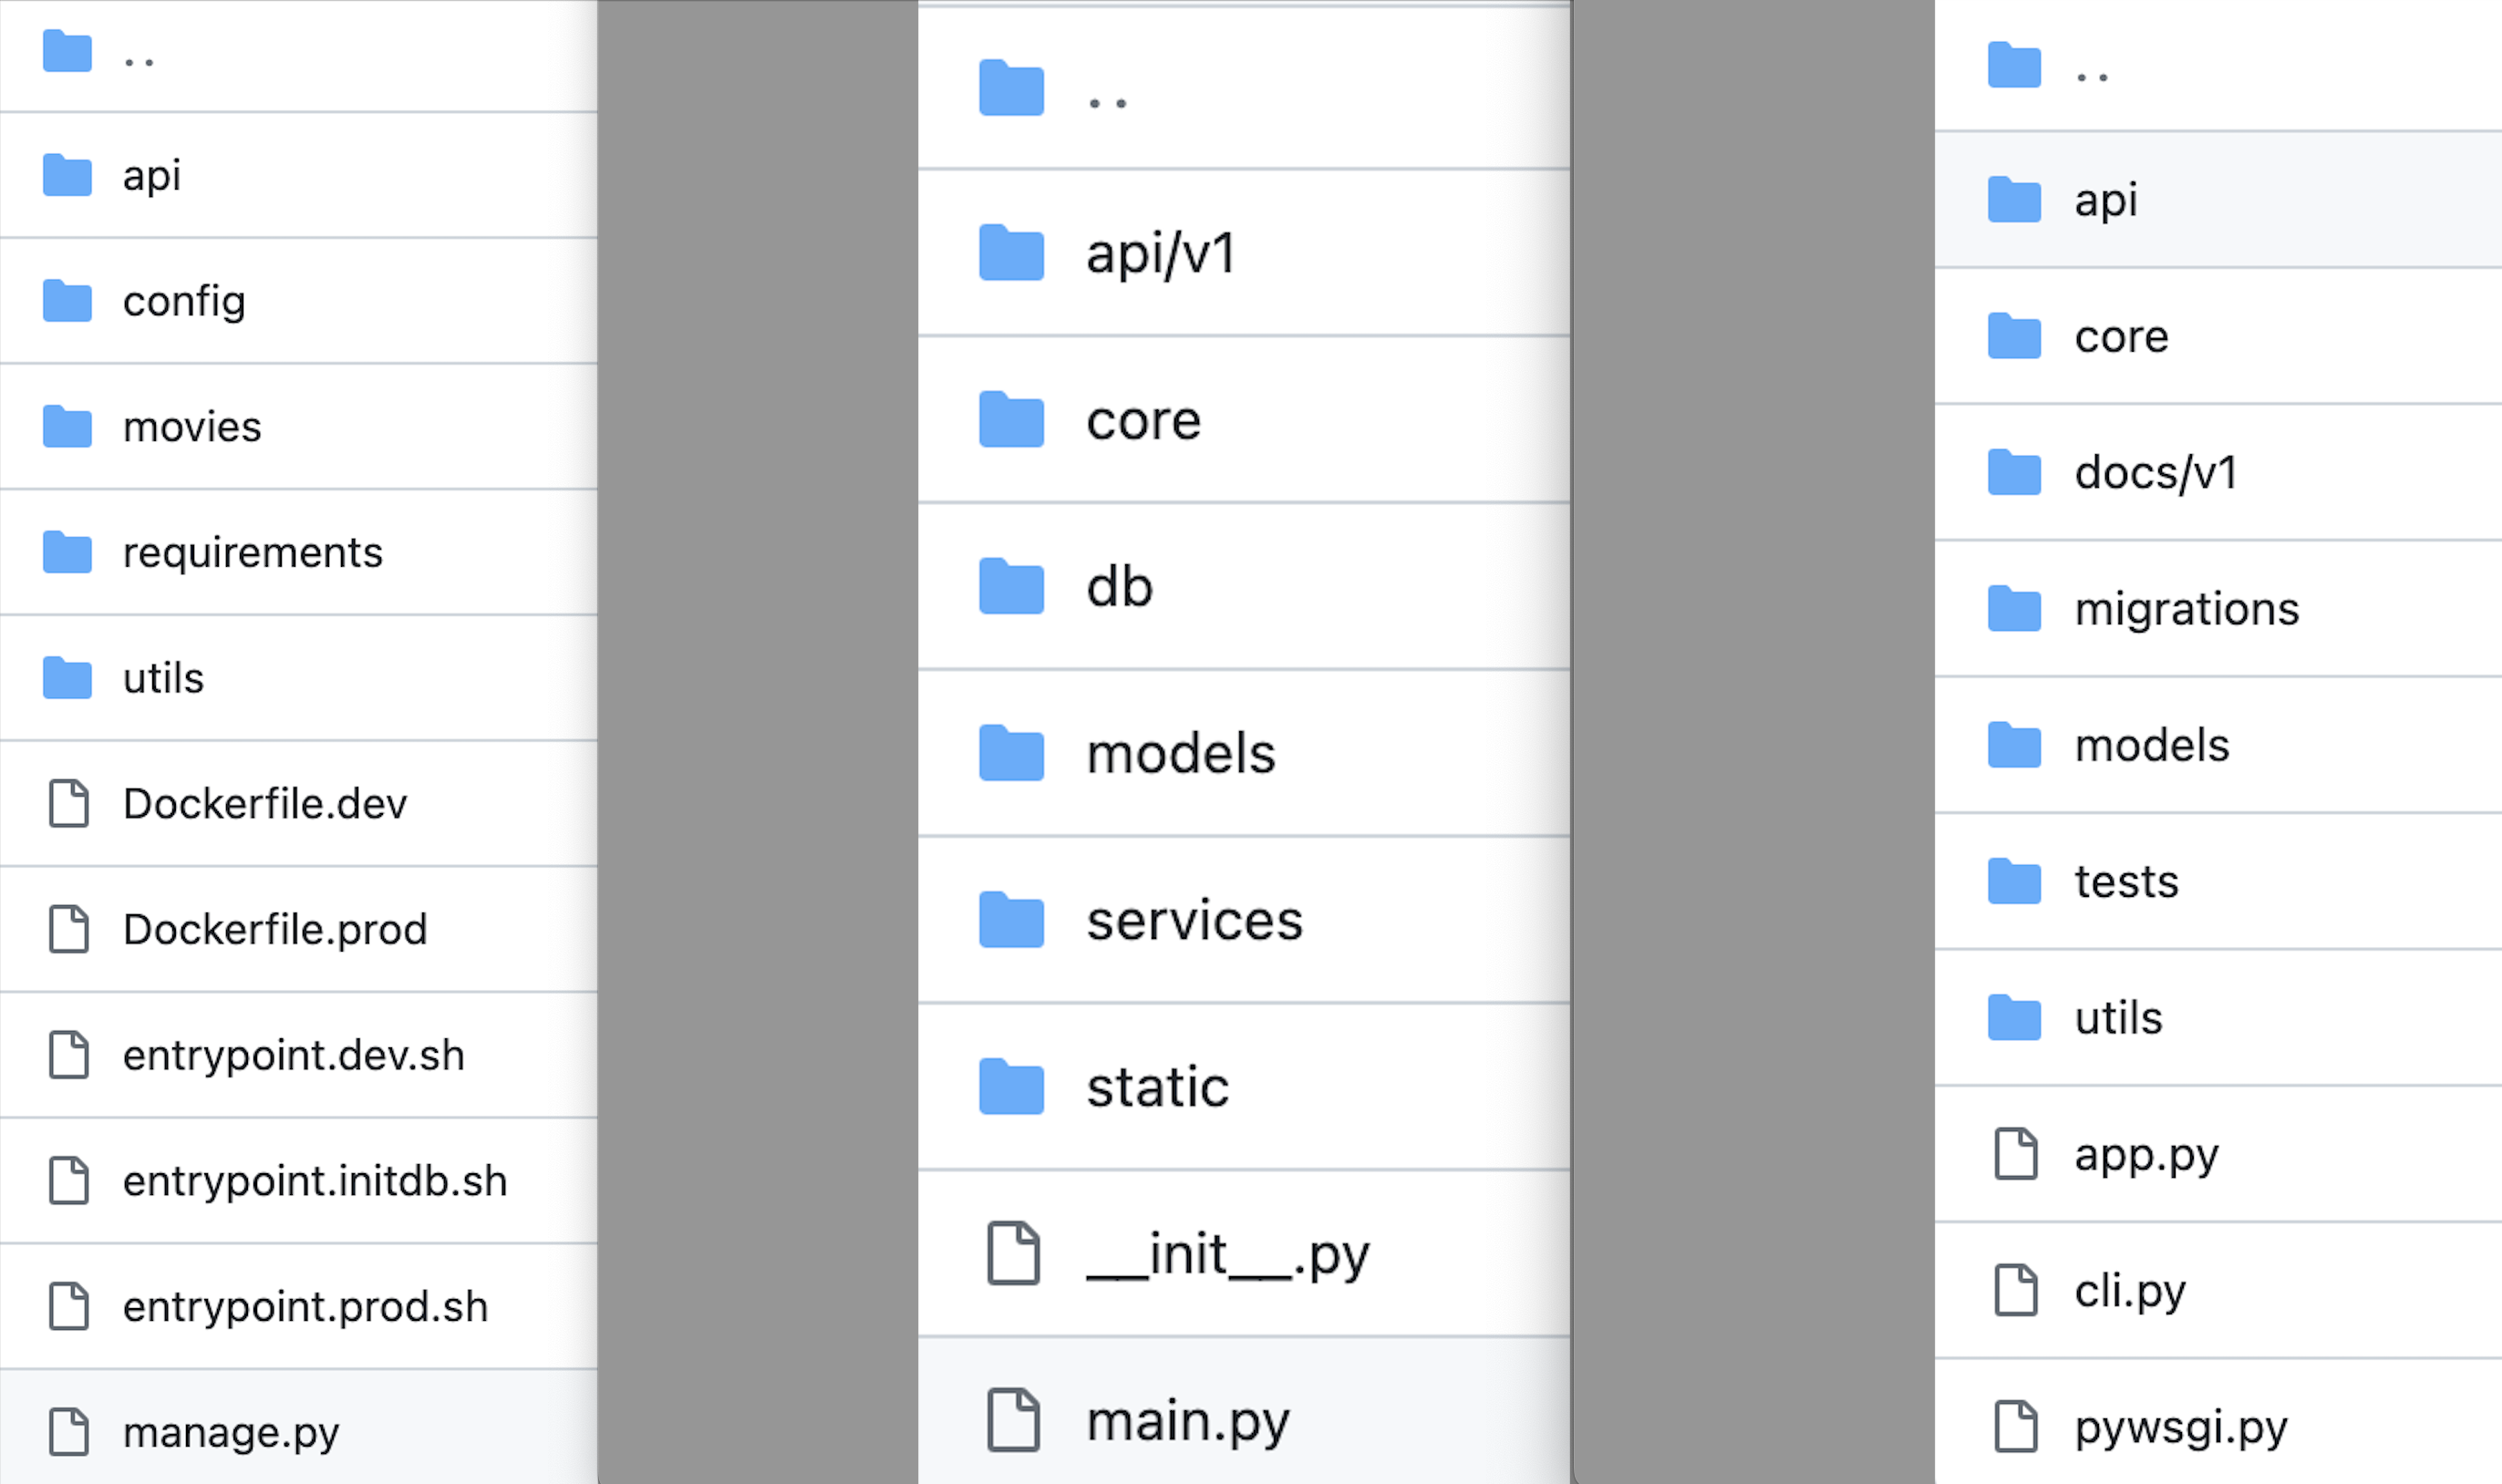

### ВЕБ - это всего лишь устройство ввода-вывода!

### Архитектура - это замысел системы.

### Фреймворки, бд, другие инструменты - это детали, которые должны быть скрыты, а не выставлены на показ.

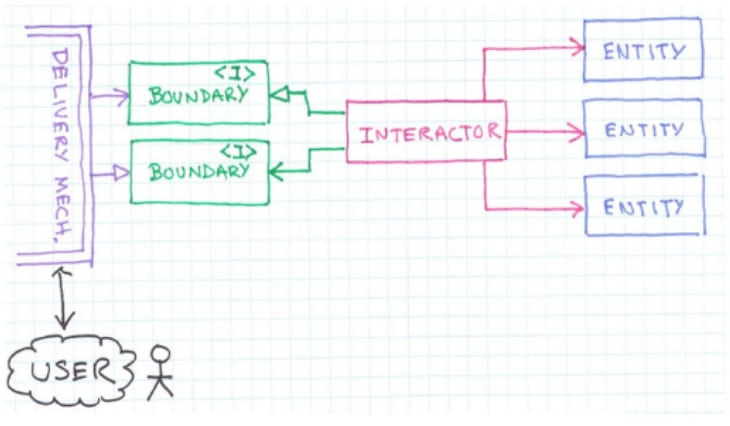

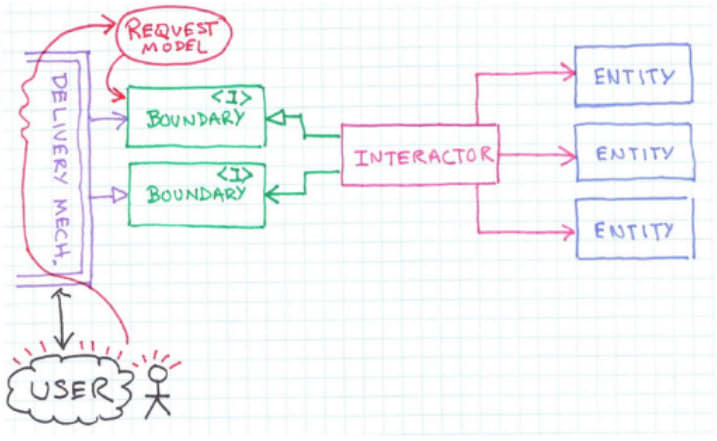

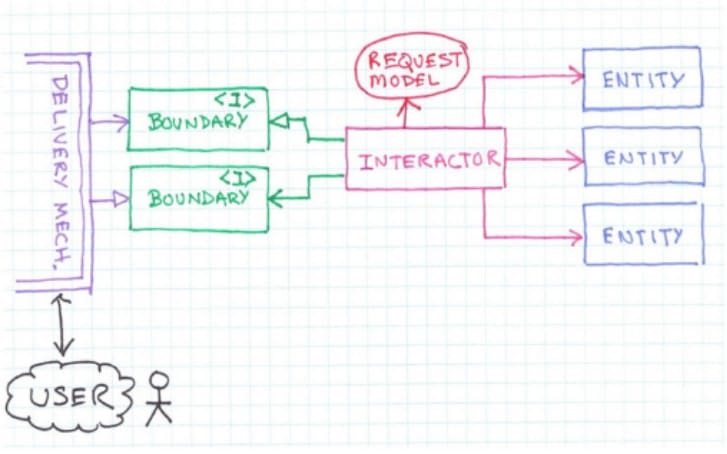

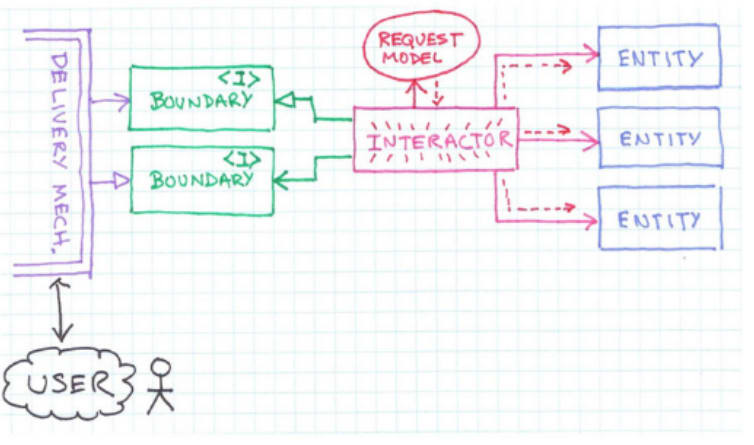

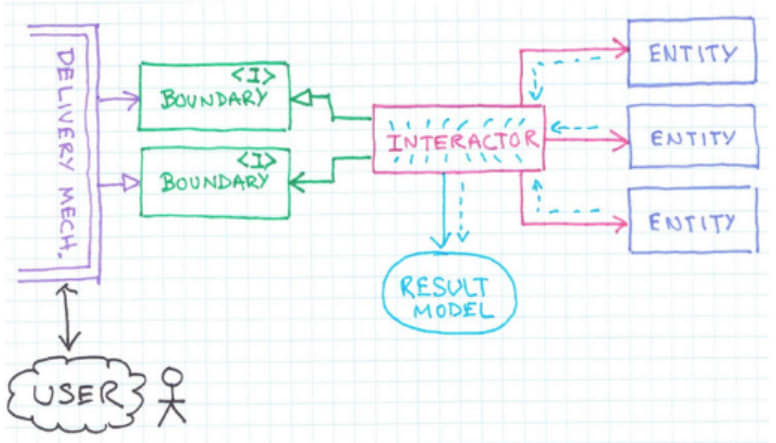

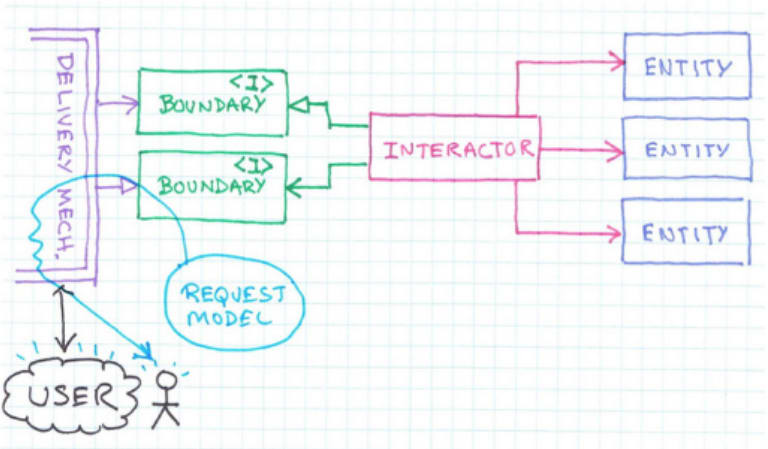

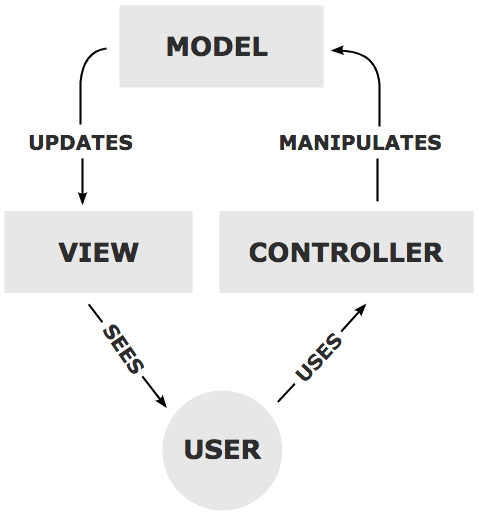

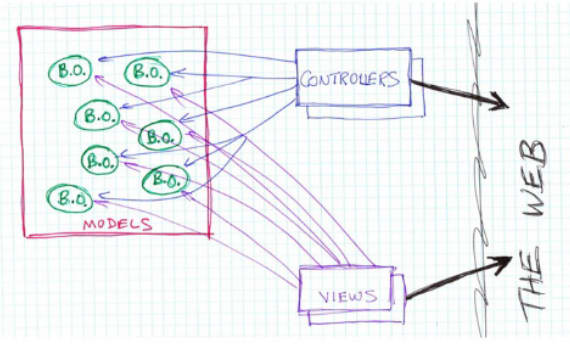

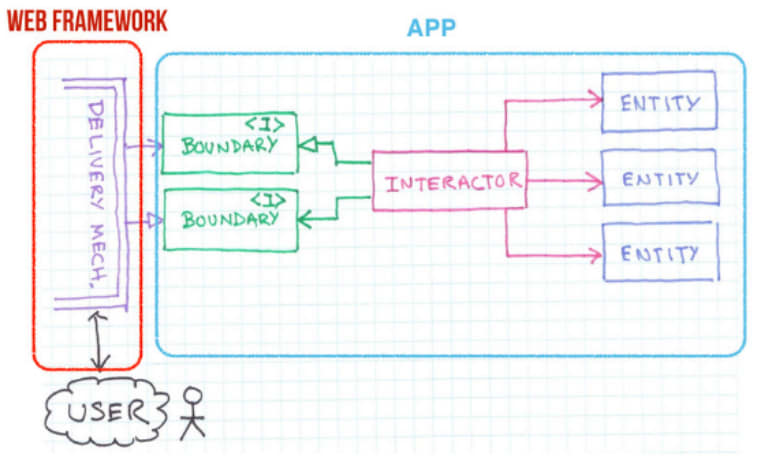

### Всем спасибо!

- https://highload.ru/
- https://github.com/HackSoftware/Django-Styleguide
- https://habr.com/ru/companies/vivid_money/articles/544856/
- https://www.youtube.com/watch?v=HpL6ymFEuu4
- https://www.youtube.com/watch?v=LPo29ygf0wA
- https://www.youtube.com/watch?v=o_TH-Y78tt4